In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense,Flatten,Input,Dropout,Activation,BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow import keras
import glob
import pandas as pd
from pycm import *
from keras_tuner.tuners import BayesianOptimization,Hyperband

เทรน Model รอบแรก

In [2]:
def create_model():

    base_model  = InceptionV3(weights='imagenet',include_top=False,input_tensor = Input(shape = (224,224,3)))

    x=base_model.output
    x=Flatten()(x)
    x=Dense(1024,activation="relu")(x)
    x=Dropout(0.3)(x)
    x=Dense(1024)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Dropout(0.3)(x)
    x=Dense(512,activation="relu")(x)
    preds=Dense(400,activation='softmax')(x)

    model=keras.Model(inputs=base_model.input,outputs=preds)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=["accuracy"])
    
    return model

In [3]:
def build_data_generator(batch_size):
  #create DataGenerator Object
  datagen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      zoom_range=0.15,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.15,
      horizontal_flip=True,
      fill_mode="nearest"
      )
  
  test_datagen= ImageDataGenerator(
      rescale=1./255
      )
  
  train_generator = datagen.flow_from_directory(
      directory="bird/train",
      target_size=(224, 224),
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=42
      )
  
  val_generator=test_datagen.flow_from_directory(
      "bird/valid",
      target_size=(224,224),
      color_mode='rgb',
      batch_size=batch_size,
      class_mode="categorical", seed = 42,
      shuffle=True
      )
  test_generator = test_datagen.flow_from_directory(
      "bird/test",
      class_mode="categorical",
      target_size=(224, 224),
      color_mode="rgb",
      shuffle=False, seed=42,
      batch_size = batch_size
      )
  
  return train_generator , val_generator , test_generator

In [4]:
EP = 32 # Number of Epoches
Batch_size = 64

In [5]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [6]:
train_generator , val_generator , test_generator = build_data_generator(Batch_size)

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [7]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_filepath = 'checkpoint'#'/content/drive/MyDrive/Bird/Checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose = 1)

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch= train_generator.n//train_generator.batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    epochs=EP,
    callbacks = [model_checkpoint_callback,stop_early]
    )

In [ ]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.plot(history.history["accuracy"], label="Train_acc")
plt.plot(history.history["val_accuracy"], label="Validate_acc")
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'validate_acc'], loc='upper left')

In [ ]:
plt.plot(history.history['loss'], label="Train_loss")
plt.plot(history.history['val_loss'], label="Validate_loss")
plt.title('Training Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validate_loss'], loc='upper left')

In [ ]:
y_true = test_generator.classes
y_true

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,5):
    batch = test_generator.next()
    Img_train = (batch[0]*255)
    plt.subplot(5,4,i)
    plt.imshow(Img_train[0].astype("uint8"))
    plt.title('RGB')

In [ ]:
test_generator.reset()
pred_prob = []
pred=model.predict_generator(test_generator)
for i in range(len(y_true)):
    pred_prob.append(np.array(pred[i]))

In [ ]:
df_pred = pd.DataFrame(pred_prob)
df_pred

In [ ]:
df_class = df_pred.idxmax(axis=1)
cm3 = ConfusionMatrix(y_true, list(df_class))
cm3.save_html("defaultHtml")

Hyperparameter Bayesian Optimization

In [30]:
def create_hyper_model(hp):
    
    #model
    base_model  = InceptionV3(weights='imagenet',include_top=False,input_tensor = Input(shape = (224,224,3)))
    #architecture
    x=base_model.output
    x=Flatten()(x)
    
    layer_num = hp.Int("num_layers", 2, 4)
    for i in range(layer_num):
        x = Dense(hp.Int(f"dense_{i}", min_value=128, max_value=1024, step=128))(x)
        x=  Dropout(hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.5, step=0.1))(x)
        if hp.Boolean(f"BatchNormalization_{i}"):
            x=  BatchNormalization()(x)
        x = Activation(hp.Choice(f"activation_{i}", ["relu", "tanh"]))(x)
    preds=Dense(400,activation='softmax')(x)


    model=keras.Model(inputs=base_model.input,outputs=preds)

    for layer in base_model.layers:
        layer.trainable = False
        
        
    hp_optimizer = hp.Choice("optimizer",values = ["adam","SGD","RMSprop"])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    #default optimizer
    optimizer = None
    if hp_optimizer == "adam":
        optimizer = Adam(learning_rate = hp_learning_rate)
    elif hp_optimizer == "SGD":
        optimizer = SGD(learning_rate = hp_learning_rate)
    elif hp_optimizer == "RMSprop":
        optimizer = RMSprop(learning_rate = hp_learning_rate)
    hp_loss = hp.Choice("loss",values = ["categorical_crossentropy","kullback_leibler_divergence"])
    model.compile(optimizer=optimizer,loss=hp_loss,metrics = "accuracy")
    
    return model

In [20]:
tuner = BayesianOptimization(create_hyper_model,
                         objective=["val_accuracy"],
                             max_trials=6,
                             overwrite=True,
                             directory='Bayestuner_Dir',
                              project_name='Bayes',
                            )

In [21]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_generator, 
             epochs=32, 
             validation_data=val_generator,
             callbacks=[stop_early])

Trial 6 Complete [03h 33m 21s]
multi_objective: -0.7870000004768372

Best multi_objective So Far: -0.8199999928474426
Total elapsed time: 18h 11m 26s
INFO:tensorflow:Oracle triggered exit


In [25]:
best_hps = tuner.get_best_hyperparameters(2)
model = create_hyper_model(best_hps[0])
model.save('save_model/best_modelbayes.h5')

ทำ HyperBand Parameter Tuning

In [31]:
tuner = Hyperband(create_hyper_model,
                         objective=["val_accuracy"],
                             overwrite=True,
                              max_epochs = 32,
                             directory='Hyperband_dir',
                              project_name='Hyper',
                            )

In [32]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_generator,
             validation_data=val_generator,
             callbacks=[stop_early])

Trial 53 Complete [00h 24m 49s]
multi_objective: -0.025499999523162842

Best multi_objective So Far: -0.9304999709129333
Total elapsed time: 17h 06m 23s

Search: Running Trial #54

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_layers
256               |768               |dense_0
0.5               |0.3               |dropout_0
False             |True              |BatchNormalization_0
tanh              |tanh              |activation_0
512               |896               |dense_1
0.4               |0.2               |dropout_1
True              |False             |BatchNormalization_1
tanh              |relu              |activation_1
SGD               |adam              |optimizer
0.01              |0.0001            |learning_rate
kullback_leible...|kullback_leible...|loss
512               |768               |dense_2
0.2               |0.2               |dropout_2
False             |False             |BatchNormalization_2
tanh         

KeyboardInterrupt: 

In [35]:
def create_hyperband_model():
    
    #model
    base_model  = InceptionV3(weights='imagenet',include_top=False,input_tensor = Input(shape = (224,224,3)))
    #architecture
    x=base_model.output
    x=Flatten()(x)
    
    x = Dense(738)(x)
    x=  Dropout(0.3)(x)
    x=  BatchNormalization()(x)
    x = Activation("tanh")(x)
    x = Dense(896)(x)
    x=  Dropout(0.2)(x)
    x = Activation("relu")(x)
    preds=Dense(400,activation='softmax')(x)


    model=keras.Model(inputs=base_model.input,outputs=preds)

    for layer in base_model.layers:
        layer.trainable = False
        
        
    model.compile(optimizer=Adam(learning_rate = 0.0001),loss="kullback_leibler_divergence",metrics = "accuracy")
    
    return model

In [36]:
model = create_hyperband_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_190 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

 batch_normalization_195 (Batch  (None, 25, 25, 64)  192         ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_197 (Batch  (None, 25, 25, 64)  192         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_200 (Batch  (None, 25, 25, 96)  288         ['conv2d_198[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_201 (Batch  (None, 25, 25, 32)  96          ['conv2d_199[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_212 (Batch  (None, 25, 25, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_215 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_212[0][0]']
                                                                                                  
 conv2d_208 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_211 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_215[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_219[0][0]',         
                                                                  'activation_222[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_222 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_nor

                                                                  'activation_231[0][0]',         
                                                                  'activation_232[0][0]']         
                                                                                                  
 conv2d_232 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_234 (Batch  (None, 12, 12, 160)  480        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_237 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_234[0][0]']
                                                                                                  
 conv2d_23

 batch_normalization_244 (Batch  (None, 12, 12, 160)  480        ['conv2d_242[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_247 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_244[0][0]']
                                                                                                  
 conv2d_243 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_247[0][0]']         
                                                                                                  
 batch_normalization_245 (Batch  (None, 12, 12, 160)  480        ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_253 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_257[0][0]']         
                                                                                                  
 batch_normalization_255 (Batch  (None, 12, 12, 192)  576        ['conv2d_253[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_258 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_255[0][0]']
                                                                                                  
 conv2d_249 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_254 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_258[0][0]']         
          

 activation_266 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_263[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_262 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_266[0][0]']         
                                                                                                  
 batch_normalization_260 (Batch  (None, 12, 12, 192)  576        ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_264 (Batch  (None, 12, 12, 192)  576        ['conv2d_262[0][0]']             
 Normaliza

 conv2d_272 (Conv2D)            (None, 5, 5, 192)    245760      ['average_pooling2d_25[0][0]']   
                                                                                                  
 batch_normalization_266 (Batch  (None, 5, 5, 320)   960         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_271 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_268[0][0]']
                                                                                                  
 activation_272 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_269[0][0]']
                                                                                                  
 activation_275 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_272[0][0]']
          

                                                                                                  
 activation_281 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_278[0][0]']
                                                                                                  
 activation_284 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_281[0][0]']
                                                                                                  
 activation_285 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_282[0][0]']
                                                                                                  
 batch_normalization_283 (Batch  (None, 5, 5, 192)   576         ['conv2d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [38]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_filepath = 'Hyperbandcheckpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose = 1)

In [39]:
hyperbandhistory = model.fit_generator(
    generator=train_generator,
    steps_per_epoch= train_generator.n//train_generator.batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    epochs=EP,
    callbacks = [model_checkpoint_callback,stop_early]
    )

C:\Users\ryu\AppData\Local\Temp\ipykernel_8744\1476471888.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hyperbandhistory = model.fit_generator(


Epoch 1/32
456/456 [==============================] - ETA: 0s - loss: 3.7834 - accuracy: 0.2844
Epoch 1: val_accuracy improved from -inf to 0.62865, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 389s 849ms/step - loss: 3.7834 - accuracy: 0.2844 - val_loss: 1.7230 - val_accuracy: 0.6286
Epoch 2/32
456/456 [==============================] - ETA: 0s - loss: 2.0770 - accuracy: 0.5361
Epoch 2: val_accuracy improved from 0.62865 to 0.76667, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 385s 844ms/step - loss: 2.0770 - accuracy: 0.5361 - val_loss: 0.9673 - val_accuracy: 0.7667
Epoch 3/32
456/456 [==============================] - ETA: 0s - loss: 1.5616 - accuracy: 0.6224
Epoch 3: val_accuracy improved from 0.76667 to 0.82708, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 401s 879ms/step - loss: 1.5616 - accuracy: 0.6224 - val_loss: 0.6915 - val_accuracy: 0.8271
Epoch 4/32
456/456 [==============================] - ETA: 0s - loss: 1.3252 - accuracy: 0.6674
Epoch 4: val_accuracy improved from 0.82708 to 0.85208, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 403s 884ms/step - loss: 1.3252 - accuracy: 0.6674 - val_loss: 0.5590 - val_accuracy: 0.8521
Epoch 5/32
456/456 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.6966
Epoch 5: val_accuracy improved from 0.85208 to 0.86615, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 416s 912ms/step - loss: 1.1775 - accuracy: 0.6966 - val_loss: 0.4900 - val_accuracy: 0.8661
Epoch 6/32
456/456 [==============================] - ETA: 0s - loss: 1.0819 - accuracy: 0.7179
Epoch 6: val_accuracy improved from 0.86615 to 0.87187, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 412s 903ms/step - loss: 1.0819 - accuracy: 0.7179 - val_loss: 0.4406 - val_accuracy: 0.8719
Epoch 7/32
456/456 [==============================] - ETA: 0s - loss: 1.0077 - accuracy: 0.7343
Epoch 7: val_accuracy improved from 0.87187 to 0.88906, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 419s 918ms/step - loss: 1.0077 - accuracy: 0.7343 - val_loss: 0.4060 - val_accuracy: 0.8891
Epoch 8/32
456/456 [==============================] - ETA: 0s - loss: 0.9689 - accuracy: 0.7428
Epoch 8: val_accuracy improved from 0.88906 to 0.89896, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 423s 927ms/step - loss: 0.9689 - accuracy: 0.7428 - val_loss: 0.3641 - val_accuracy: 0.8990
Epoch 9/32
456/456 [==============================] - ETA: 0s - loss: 0.9254 - accuracy: 0.7512
Epoch 9: val_accuracy improved from 0.89896 to 0.90365, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 417s 913ms/step - loss: 0.9254 - accuracy: 0.7512 - val_loss: 0.3457 - val_accuracy: 0.9036
Epoch 10/32
456/456 [==============================] - ETA: 0s - loss: 0.8766 - accuracy: 0.7616
Epoch 10: val_accuracy improved from 0.90365 to 0.91198, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 414s 908ms/step - loss: 0.8766 - accuracy: 0.7616 - val_loss: 0.3190 - val_accuracy: 0.9120
Epoch 11/32
456/456 [==============================] - ETA: 0s - loss: 0.8564 - accuracy: 0.7656
Epoch 11: val_accuracy improved from 0.91198 to 0.91406, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 428s 938ms/step - loss: 0.8564 - accuracy: 0.7656 - val_loss: 0.3167 - val_accuracy: 0.9141
Epoch 12/32
456/456 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.7752
Epoch 12: val_accuracy did not improve from 0.91406
456/456 [==============================] - 402s 882ms/step - loss: 0.8221 - accuracy: 0.7752 - val_loss: 0.3175 - val_accuracy: 0.9089
Epoch 13/32
456/456 [==============================] - ETA: 0s - loss: 0.8011 - accuracy: 0.7793
Epoch 13: val_accuracy improved from 0.91406 to 0.91719, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 414s 908ms/step - loss: 0.8011 - accuracy: 0.7793 - val_loss: 0.2985 - val_accuracy: 0.9172
Epoch 14/32
456/456 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.7852
Epoch 14: val_accuracy did not improve from 0.91719
456/456 [==============================] - 398s 873ms/step - loss: 0.7780 - accuracy: 0.7852 - val_loss: 0.2854 - val_accuracy: 0.9151
Epoch 15/32
456/456 [==============================] - ETA: 0s - loss: 0.7567 - accuracy: 0.7915
Epoch 15: val_accuracy did not improve from 0.91719
456/456 [==============================] - 405s 889ms/step - loss: 0.7567 - accuracy: 0.7915 - val_loss: 0.2737 - val_accuracy: 0.9172
Epoch 16/32
456/456 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7962
Epoch 16: val_accuracy did not improve from 0.91719
456/456 [==============================] - 402s 881ms/step - loss: 0.7367 - accuracy: 0.7962 - val_loss: 0.2768 - val_accuracy: 0.9151
Epoch 17/32
4

INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 493s 1s/step - loss: 0.7307 - accuracy: 0.7986 - val_loss: 0.2709 - val_accuracy: 0.9193
Epoch 18/32
456/456 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.8028
Epoch 18: val_accuracy improved from 0.91927 to 0.92708, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 481s 1s/step - loss: 0.7102 - accuracy: 0.8028 - val_loss: 0.2537 - val_accuracy: 0.9271
Epoch 19/32
456/456 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.8061
Epoch 19: val_accuracy did not improve from 0.92708
456/456 [==============================] - 400s 876ms/step - loss: 0.6931 - accuracy: 0.8061 - val_loss: 0.2618 - val_accuracy: 0.9214
Epoch 20/32
456/456 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.8096
Epoch 20: val_accuracy improved from 0.92708 to 0.92865, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 419s 918ms/step - loss: 0.6804 - accuracy: 0.8096 - val_loss: 0.2480 - val_accuracy: 0.9286
Epoch 21/32
456/456 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.8117
Epoch 21: val_accuracy did not improve from 0.92865
456/456 [==============================] - 404s 884ms/step - loss: 0.6674 - accuracy: 0.8117 - val_loss: 0.2419 - val_accuracy: 0.9286
Epoch 22/32
456/456 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.8149
Epoch 22: val_accuracy improved from 0.92865 to 0.93385, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 427s 935ms/step - loss: 0.6598 - accuracy: 0.8149 - val_loss: 0.2335 - val_accuracy: 0.9339
Epoch 23/32
456/456 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.8163
Epoch 23: val_accuracy did not improve from 0.93385
456/456 [==============================] - 404s 886ms/step - loss: 0.6507 - accuracy: 0.8163 - val_loss: 0.2448 - val_accuracy: 0.9333
Epoch 24/32
456/456 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.8203
Epoch 24: val_accuracy improved from 0.93385 to 0.94063, saving model to Hyperbandcheckpoint


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


INFO:tensorflow:Assets written to: Hyperbandcheckpoint\assets


456/456 [==============================] - 420s 922ms/step - loss: 0.6370 - accuracy: 0.8203 - val_loss: 0.2216 - val_accuracy: 0.9406
Epoch 25/32
456/456 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.8196
Epoch 25: val_accuracy did not improve from 0.94063
456/456 [==============================] - 392s 858ms/step - loss: 0.6328 - accuracy: 0.8196 - val_loss: 0.2243 - val_accuracy: 0.9302
Epoch 26/32
456/456 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.8238
Epoch 26: val_accuracy did not improve from 0.94063
456/456 [==============================] - 399s 874ms/step - loss: 0.6205 - accuracy: 0.8238 - val_loss: 0.2119 - val_accuracy: 0.9359
Epoch 27/32
456/456 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.8298
Epoch 27: val_accuracy did not improve from 0.94063
456/456 [==============================] - 394s 863ms/step - loss: 0.6045 - accuracy: 0.8298 - val_loss: 0.2180 - val_accuracy: 0.9365
Epoch 28/32
4

In [40]:
model.save('save_model/hyperband_modelsave0.h5')

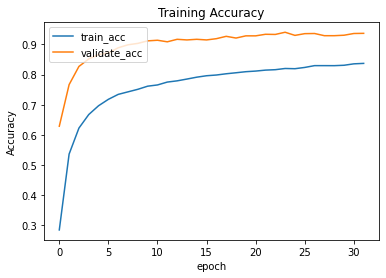

In [41]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.plot(hyperbandhistory.history["accuracy"], label="Train_acc")
plt.plot(hyperbandhistory.history["val_accuracy"], label="Validate_acc")
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'validate_acc'], loc='upper left')

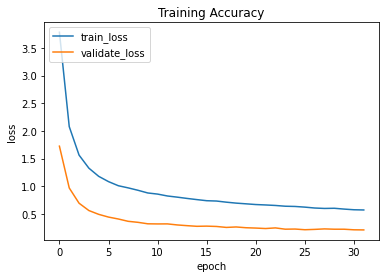

In [42]:
plt.plot(hyperbandhistory.history['loss'], label="Train_loss")
plt.plot(hyperbandhistory.history['val_loss'], label="Validate_loss")
plt.title('Training Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validate_loss'], loc='upper left')

In [43]:
y_true = test_generator.classes
y_true

array([  0,   0,   0, ..., 399, 399, 399])

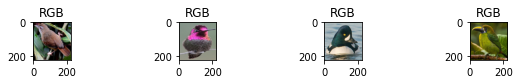

In [44]:
plt.figure(figsize=(10,4))
for i in range(1,5):
    batch = test_generator.next()
    Img_train = (batch[0]*255)
    plt.subplot(5,4,i)
    plt.imshow(Img_train[0].astype("uint8"))
    plt.title('RGB')

In [46]:
test_generator.reset()
pred_prob = []
pred=model.predict_generator(test_generator)
for i in range(len(y_true)):
    pred_prob.append(np.array(pred[i]))

C:\Users\ryu\AppData\Local\Temp\ipykernel_8744\4136271206.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator)


In [47]:
df_pred = pd.DataFrame(pred_prob)
df_pred

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,8.972239e-01,4.118325e-07,7.834086e-09,1.909348e-10,4.072343e-08,1.111216e-04,1.383186e-10,1.724553e-11,3.576082e-03,8.706433e-12,...,3.595939e-06,7.003432e-10,7.437088e-11,2.873474e-10,1.683895e-10,1.120958e-06,4.747245e-10,6.393783e-05,2.801036e-07,2.058767e-07
1,2.968646e-01,4.958514e-06,9.161965e-10,5.469471e-10,6.357700e-05,5.592098e-04,3.332993e-09,7.854923e-08,4.544512e-04,3.101923e-06,...,1.966963e-05,3.005664e-08,2.281387e-08,5.599697e-07,2.800136e-10,5.225917e-07,6.121202e-08,2.807187e-02,1.039715e-07,1.789097e-08
2,5.330798e-01,2.662246e-06,1.138484e-07,1.106305e-08,1.498301e-05,1.569598e-05,1.689582e-10,1.011397e-08,3.977865e-04,5.722264e-09,...,1.984354e-06,1.912284e-07,6.111468e-07,1.238916e-06,5.546046e-10,9.188429e-07,1.790266e-08,1.641520e-02,3.488960e-06,5.577636e-07
3,5.213212e-03,2.437622e-08,1.161440e-10,1.985552e-12,1.225732e-08,5.463820e-08,4.126589e-12,1.401166e-12,2.187440e-07,1.309644e-12,...,1.265224e-10,5.824749e-10,1.834727e-10,3.845491e-10,3.032578e-11,2.615474e-10,9.607449e-11,3.609545e-09,1.274581e-09,2.281588e-09
4,9.834055e-01,1.179215e-08,1.186466e-09,2.107347e-11,6.460049e-10,6.551555e-05,1.703772e-10,3.555954e-10,1.013716e-04,3.146352e-11,...,2.813590e-06,1.213371e-11,3.103971e-11,1.172822e-09,2.170984e-11,2.688575e-07,2.007045e-09,2.656276e-04,7.476232e-09,5.921814e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.172350e-13,6.296837e-11,7.145251e-10,1.195112e-10,2.022456e-11,1.345512e-09,9.505123e-14,3.658186e-12,2.631846e-14,9.449994e-13,...,1.040524e-09,3.445594e-11,1.198689e-10,1.059163e-09,9.096022e-12,4.301890e-07,3.215260e-13,3.485932e-10,9.580858e-07,9.998773e-01
1996,3.361829e-11,5.725676e-09,7.907421e-10,4.831246e-11,2.415260e-09,2.614116e-07,7.613951e-11,3.374291e-11,1.628692e-09,2.804780e-11,...,5.452963e-09,1.602448e-09,1.151736e-08,5.324982e-08,2.121225e-11,3.043402e-09,1.507434e-11,5.456389e-08,4.790314e-07,9.966454e-01
1997,1.696374e-11,2.636294e-09,4.248848e-09,7.313559e-11,1.557817e-09,1.413628e-07,3.875568e-10,4.616695e-12,4.189849e-10,1.803550e-12,...,2.307069e-09,7.230978e-10,4.371963e-10,1.939962e-09,2.453219e-11,5.950736e-08,1.012936e-11,9.858466e-07,8.647864e-06,9.981508e-01
1998,3.882630e-05,5.424066e-06,5.158725e-07,1.531201e-09,3.578950e-08,2.980473e-02,8.964940e-06,1.359491e-06,1.589873e-03,4.676945e-09,...,8.434139e-07,5.230330e-06,1.792259e-07,1.166984e-07,2.418193e-06,2.097602e-07,3.493590e-08,1.697272e-06,6.133685e-09,2.914565e-01


In [49]:
df_class = df_pred.idxmax(axis=1)

In [50]:
print(classification_report(y_true, df_class))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      0.20      0.33         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.71      1.00      0.83         5
          17       1.00    

C:\Users\ryu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ryu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ryu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

ทำ FINE TUNE

In [5]:
model = keras.models.load_model('save_model/hyperband_modelsave0.h5')

In [6]:
def print_layer_trainable(conv_model):
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [7]:
print_layer_trainable(model)

True:	input_3
False:	conv2d_188
False:	batch_normalization_190
False:	activation_193
False:	conv2d_189
False:	batch_normalization_191
False:	activation_194
False:	conv2d_190
False:	batch_normalization_192
False:	activation_195
False:	max_pooling2d_8
False:	conv2d_191
False:	batch_normalization_193
False:	activation_196
False:	conv2d_192
False:	batch_normalization_194
False:	activation_197
False:	max_pooling2d_9
False:	conv2d_196
False:	batch_normalization_198
False:	activation_201
False:	conv2d_194
False:	conv2d_197
False:	batch_normalization_196
False:	batch_normalization_199
False:	activation_199
False:	activation_202
False:	average_pooling2d_18
False:	conv2d_193
False:	conv2d_195
False:	conv2d_198
False:	conv2d_199
False:	batch_normalization_195
False:	batch_normalization_197
False:	batch_normalization_200
False:	batch_normalization_201
False:	activation_198
False:	activation_200
False:	activation_203
False:	activation_204
False:	mixed0
False:	conv2d_203
False:	batch_normalization_2

In [8]:
for layer in model.layers[:]:
    if ('batch_normalization' in layer.name):
        trainable = False
    else:
        trainable = True
    if ('batch_normalization_284' in layer.name):
        trainable = True
    layer.trainable = trainable

In [9]:
print_layer_trainable(model)

True:	input_3
True:	conv2d_188
False:	batch_normalization_190
True:	activation_193
True:	conv2d_189
False:	batch_normalization_191
True:	activation_194
True:	conv2d_190
False:	batch_normalization_192
True:	activation_195
True:	max_pooling2d_8
True:	conv2d_191
False:	batch_normalization_193
True:	activation_196
True:	conv2d_192
False:	batch_normalization_194
True:	activation_197
True:	max_pooling2d_9
True:	conv2d_196
False:	batch_normalization_198
True:	activation_201
True:	conv2d_194
True:	conv2d_197
False:	batch_normalization_196
False:	batch_normalization_199
True:	activation_199
True:	activation_202
True:	average_pooling2d_18
True:	conv2d_193
True:	conv2d_195
True:	conv2d_198
True:	conv2d_199
False:	batch_normalization_195
False:	batch_normalization_197
False:	batch_normalization_200
False:	batch_normalization_201
True:	activation_198
True:	activation_200
True:	activation_203
True:	activation_204
True:	mixed0
True:	conv2d_203
False:	batch_normalization_205
True:	activation_208
True:

In [10]:
model.compile(optimizer=Adam(learning_rate = 0.00001),loss="kullback_leibler_divergence",metrics = "accuracy")

In [11]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_filepath = 'fineTuneCheckpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose = 1)

In [12]:
fineTuneHistory = model.fit_generator(
    generator=train_generator,
    steps_per_epoch= train_generator.n//train_generator.batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    epochs=EP,
    callbacks = [model_checkpoint_callback,stop_early]
    )

C:\Users\ryu\AppData\Local\Temp\ipykernel_13264\2130728263.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fineTuneHistory = model.fit_generator(


Epoch 1/32
912/912 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8786
Epoch 1: val_accuracy improved from -inf to 0.95817, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 509s 544ms/step - loss: 0.4245 - accuracy: 0.8786 - val_loss: 0.1413 - val_accuracy: 0.9582
Epoch 2/32
912/912 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8990
Epoch 2: val_accuracy improved from 0.95817 to 0.96321, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 425s 465ms/step - loss: 0.3480 - accuracy: 0.8990 - val_loss: 0.1181 - val_accuracy: 0.9632
Epoch 3/32
912/912 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.9112
Epoch 3: val_accuracy improved from 0.96321 to 0.96623, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 430s 471ms/step - loss: 0.3036 - accuracy: 0.9112 - val_loss: 0.1125 - val_accuracy: 0.9662
Epoch 4/32
912/912 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.9204
Epoch 4: val_accuracy improved from 0.96623 to 0.96673, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 437s 479ms/step - loss: 0.2723 - accuracy: 0.9204 - val_loss: 0.0994 - val_accuracy: 0.9667
Epoch 5/32
912/912 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9278
Epoch 5: val_accuracy improved from 0.96673 to 0.97177, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 430s 471ms/step - loss: 0.2472 - accuracy: 0.9278 - val_loss: 0.0951 - val_accuracy: 0.9718
Epoch 6/32
912/912 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9323
Epoch 6: val_accuracy did not improve from 0.97177
912/912 [==============================] - 407s 445ms/step - loss: 0.2288 - accuracy: 0.9323 - val_loss: 0.0943 - val_accuracy: 0.9713
Epoch 7/32
912/912 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9373
Epoch 7: val_accuracy improved from 0.97177 to 0.97228, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 414s 453ms/step - loss: 0.2120 - accuracy: 0.9373 - val_loss: 0.0894 - val_accuracy: 0.9723
Epoch 8/32
912/912 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9430
Epoch 8: val_accuracy improved from 0.97228 to 0.97631, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 413s 452ms/step - loss: 0.1948 - accuracy: 0.9430 - val_loss: 0.0880 - val_accuracy: 0.9763
Epoch 9/32
912/912 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9470
Epoch 9: val_accuracy did not improve from 0.97631
912/912 [==============================] - 390s 428ms/step - loss: 0.1797 - accuracy: 0.9470 - val_loss: 0.0907 - val_accuracy: 0.9728
Epoch 10/32
912/912 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9490
Epoch 10: val_accuracy did not improve from 0.97631
912/912 [==============================] - 390s 427ms/step - loss: 0.1723 - accuracy: 0.9490 - val_loss: 0.0837 - val_accuracy: 0.9733
Epoch 11/32
912/912 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9506
Epoch 11: val_accuracy did not improve from 0.97631
912/912 [==============================] - 390s 427ms/step - loss: 0.1629 - accuracy: 0.9506 - val_loss: 0.0895 - val_accuracy: 0.9718
Epoch 12/32
912

INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 409s 448ms/step - loss: 0.1430 - accuracy: 0.9577 - val_loss: 0.0782 - val_accuracy: 0.9798
Epoch 14/32
912/912 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9601
Epoch 14: val_accuracy improved from 0.97984 to 0.98135, saving model to fineTuneCheckpoint


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


INFO:tensorflow:Assets written to: fineTuneCheckpoint\assets


912/912 [==============================] - 411s 450ms/step - loss: 0.1349 - accuracy: 0.9601 - val_loss: 0.0731 - val_accuracy: 0.9814
Epoch 15/32
912/912 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9626
Epoch 15: val_accuracy did not improve from 0.98135
912/912 [==============================] - 392s 429ms/step - loss: 0.1251 - accuracy: 0.9626 - val_loss: 0.0740 - val_accuracy: 0.9778
Epoch 16/32
912/912 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9637
Epoch 16: val_accuracy did not improve from 0.98135
912/912 [==============================] - 391s 429ms/step - loss: 0.1222 - accuracy: 0.9637 - val_loss: 0.0739 - val_accuracy: 0.9814
Epoch 17/32
912/912 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9669
Epoch 17: val_accuracy did not improve from 0.98135
912/912 [==============================] - 392s 429ms/step - loss: 0.1119 - accuracy: 0.9669 - val_loss: 0.0854 - val_accuracy: 0.9758
Epoch 18/32
9

In [13]:
model.save('save_model/finetune_models.h5')

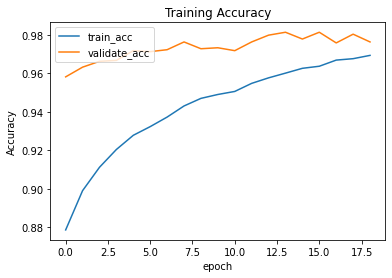

In [14]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.plot(fineTuneHistory.history["accuracy"], label="Train_acc")
plt.plot(fineTuneHistory.history["val_accuracy"], label="Validate_acc")
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'validate_acc'], loc='upper left')

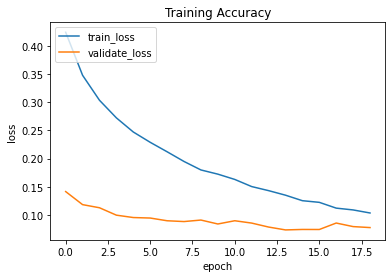

In [15]:
plt.plot(fineTuneHistory.history['loss'], label="Train_loss")
plt.plot(fineTuneHistory.history['val_loss'], label="Validate_loss")
plt.title('Training Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validate_loss'], loc='upper left')

In [10]:
y_true = test_generator.classes
y_true

array([  0,   0,   0, ..., 399, 399, 399])

In [11]:
test_generator.reset()
pred_prob = []
pred=model.predict_generator(test_generator)
for i in range(len(y_true)):
    pred_prob.append(np.array(pred[i]))

C:\Users\ryu\AppData\Local\Temp\ipykernel_4172\4136271206.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator)


In [12]:
df_pred = pd.DataFrame(pred_prob)
df_pred

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,9.759474e-01,2.287649e-08,2.048244e-11,7.197875e-12,2.074419e-09,2.125358e-06,2.466767e-13,5.231878e-12,2.532135e-05,5.034707e-14,...,1.258771e-07,2.583779e-13,1.993724e-13,1.712492e-11,2.513636e-12,1.116494e-09,6.787831e-11,3.990897e-05,1.148783e-07,9.916527e-09
1,8.660215e-01,5.086005e-07,1.328126e-11,2.551760e-12,1.618548e-07,4.499794e-03,2.149968e-10,2.633288e-09,2.598255e-05,4.957818e-09,...,1.229005e-06,5.712876e-11,4.085169e-11,1.117733e-08,8.890768e-12,4.647363e-07,2.137625e-09,9.871848e-03,2.823319e-08,5.229154e-09
2,9.903231e-01,7.519188e-10,4.249614e-12,1.258051e-12,4.564156e-08,1.713650e-07,1.217648e-13,2.578643e-11,8.131024e-07,1.013344e-12,...,8.216742e-08,3.388941e-12,7.799824e-12,1.313311e-09,8.177833e-14,4.828824e-09,3.937140e-11,2.000886e-03,2.977247e-08,1.364776e-09
3,8.434240e-01,8.144232e-07,2.441050e-11,2.121150e-13,2.072167e-07,5.456949e-07,2.969616e-12,6.447322e-12,1.535430e-06,7.348647e-13,...,8.330822e-10,3.630929e-11,3.280490e-11,1.292806e-09,1.412996e-09,2.372993e-10,3.730156e-09,9.137938e-09,1.545291e-10,1.251449e-10
4,9.961885e-01,3.885694e-11,2.336257e-12,3.165989e-15,6.573500e-12,2.423764e-07,2.316113e-13,2.794543e-13,5.923185e-07,9.985326e-15,...,1.092788e-09,2.259918e-14,4.136301e-14,8.915090e-12,1.020654e-14,6.453323e-11,8.935382e-12,2.947901e-06,3.007305e-13,2.521503e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4.971870e-15,2.636415e-14,2.334503e-12,1.318370e-14,8.094873e-14,1.230805e-11,6.567493e-14,3.538883e-15,1.545593e-15,3.319994e-18,...,2.554729e-12,6.325013e-13,1.886188e-15,2.318592e-14,4.469938e-13,7.068852e-11,3.047171e-16,3.150844e-12,1.051368e-09,9.999981e-01
1996,2.415411e-14,3.270896e-13,1.623108e-12,4.449223e-15,3.248947e-13,1.896068e-11,6.722306e-13,1.133011e-14,7.677404e-14,3.386209e-16,...,1.091080e-12,1.749668e-11,8.536413e-15,1.678108e-13,2.074187e-14,5.999234e-12,2.359460e-16,3.567797e-11,3.505097e-10,9.999851e-01
1997,1.885593e-13,3.188021e-13,2.336825e-12,5.600954e-15,2.027676e-12,1.710647e-11,7.581640e-13,1.917997e-15,1.863515e-13,2.781773e-16,...,1.564603e-12,1.577350e-11,2.784481e-15,5.677650e-13,8.899135e-14,7.771337e-11,6.807129e-16,5.039593e-11,2.176206e-10,9.999946e-01
1998,3.434360e-10,6.267789e-10,3.361144e-10,3.212823e-13,1.368660e-10,3.999708e-06,3.077099e-08,4.150964e-11,3.878452e-09,1.927165e-15,...,2.432449e-09,7.967545e-09,1.076287e-11,1.171310e-12,2.552241e-08,5.281019e-10,8.932174e-11,8.934495e-10,2.390511e-10,9.019634e-01


In [14]:
df_class = df_pred.idxmax(axis=1)
cm3 = ConfusionMatrix(y_true, list(df_class))
cm3.save_html("FineTuneBird")

{'Status': True, 'Message': 'H:\\Bird\\FineTuneBird.html'}

In [15]:
print(classification_report(y_true, df_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      0.80      0.89         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    